In [ ]:
# !pip uninstall sklearn
# !pip install sklearn --upgrade

In [30]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler


In [14]:
import pandas as pd

df = pd.read_csv(r"C:\Users\hp\Desktop\ML\Project\data.csv")


In [15]:
df.dropna(subset=["CustomerID"], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith("C")]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [18]:
# Choose split date
cutoff_date = df['InvoiceDate'].max() - pd.Timedelta(days=90)
print("Cutoff date:", cutoff_date)

# Observation period = before cutoff
df_obs = df[df['InvoiceDate'] <= cutoff_date]
# Prediction period = after cutoff
df_pred = df[df['InvoiceDate'] > cutoff_date]


Cutoff date: 2011-09-10 12:49:00


In [19]:
print(df_obs['InvoiceDate'].min())
print(df_obs['InvoiceDate'].max())
df_obs

2010-12-01 08:26:00
2011-09-09 15:53:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
333858,566220,23307,SET OF 60 PANTRY DESIGN CAKE CASES,120,2011-09-09 15:53:00,0.42,15251.0,United Kingdom,50.40
333859,566220,22965,3 TRADITIONAl BISCUIT CUTTERS SET,24,2011-09-09 15:53:00,2.10,15251.0,United Kingdom,50.40
333860,566220,22989,SET 2 PANTRY DESIGN TEA TOWELS,24,2011-09-09 15:53:00,3.25,15251.0,United Kingdom,78.00
333861,566220,22980,PANTRY SCRUBBING BRUSH,48,2011-09-09 15:53:00,1.45,15251.0,United Kingdom,69.60


In [20]:
print(df_pred['InvoiceDate'].min())
print(df_pred['InvoiceDate'].max())
df_pred

2011-09-11 10:35:00
2011-12-09 12:49:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
334054,566225,22384,LUNCH BAG PINK POLKADOT,6,2011-09-11 10:35:00,1.65,16899.0,United Kingdom,9.90
334055,566225,20725,LUNCH BAG RED RETROSPOT,6,2011-09-11 10:35:00,1.65,16899.0,United Kingdom,9.90
334056,566225,23169,CLASSIC GLASS COOKIE JAR,3,2011-09-11 10:35:00,4.15,16899.0,United Kingdom,12.45
334057,566225,84029E,RED WOOLLY HOTTIE WHITE HEART.,3,2011-09-11 10:35:00,4.25,16899.0,United Kingdom,12.75
334058,566225,21479,WHITE SKULL HOT WATER BOTTLE,3,2011-09-11 10:35:00,4.25,16899.0,United Kingdom,12.75
...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,214.80


## Create Features from Observation Window

In [21]:
snapshot_date = df_obs['InvoiceDate'].max()

features = df_obs.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

features.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
features = features[features['Monetary']>0]
features

,CustomerID,Recency,Frequency,Monetary
0,12346.0,234,1,77183.60
1,12747.0,18,8,2769.40
2,12748.0,0,132,14107.75
3,12749.0,39,3,2755.23
4,12820.0,235,1,170.46
...,...,...,...,...
3030,18280.0,186,1,180.60
3031,18281.0,89,1,80.82
3032,18282.0,35,1,100.21
3033,18283.0,4,10,1120.67


## Create Target CLTV from Prediction Window

In [22]:
target = df_pred.groupby('CustomerID').agg({
    'TotalPrice': 'sum'
}).reset_index()

target.columns = ['CustomerID', 'FutureCLTV']
target

,CustomerID,FutureCLTV
0,12747.0,1426.61
1,12748.0,19611.98
2,12749.0,1335.65
3,12820.0,771.88
4,12822.0,948.88
...,...,...
2609,18277.0,110.38
2610,18278.0,173.90
2611,18282.0,77.84
2612,18283.0,974.21


# Merge Features and Target

In [23]:
data = pd.merge(features, target, on='CustomerID', how='inner')
print(data.head())


   CustomerID  Recency  Frequency  Monetary  FutureCLTV
0     12747.0       18          8   2769.40     1426.61
1     12748.0        0        132  14107.75    19611.98
2     12749.0       39          3   2755.23     1335.65
3     12820.0      235          1    170.46      771.88
4     12823.0       35          4   1224.00      535.50


In [24]:
data.isnull().sum()

CustomerID    0
Recency       0
Frequency     0
Monetary      0
FutureCLTV    0
dtype: int64

## Train the Machine Learning Model

    Observation window = 2020-01-01 to 2020-09-30 → you extract RFM features here

    Prediction window = 2020-10-01 to 2020-12-31 → you calculate total money spent per customer here (target)

    So you're building a model that says:

    “Given a customer’s behavior till Sep 30, 2020, can we predict how much they’ll spend in the next 3 months?”

In [27]:

X = data[['Recency', 'Frequency', 'Monetary']]
y = data['FutureCLTV']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)




In [31]:
# Hyperparameters for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}



In [32]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist,
    n_iter=100,  # Number of different combinations to try
    cv=5,        # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}
Best cross-validation score:  0.12881890337193572


In [33]:
# Get the best model from RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Predict on test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model performance
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


R2 Score: -0.5023465906429498
RMSE: 3207.1812671191224


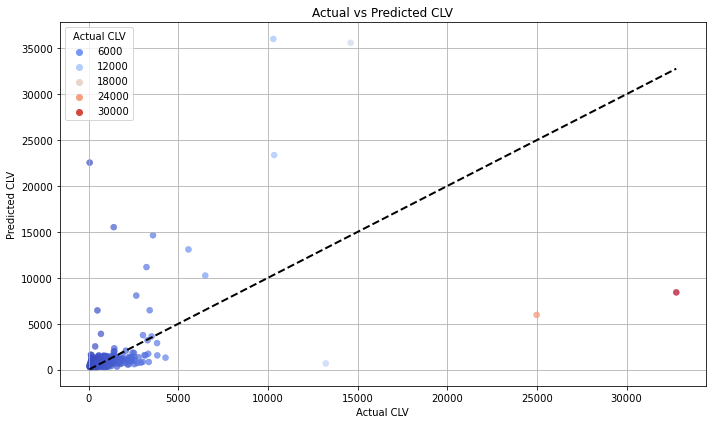

In [37]:
# Create a DataFrame for plotting
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='Actual', y='Predicted', hue='Actual',
                palette='coolwarm', alpha=0.7, edgecolor=None)

# Reference line (Perfect prediction line)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.title('Actual vs Predicted CLV')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.legend(title="Actual CLV", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
results_df

,Actual,Predicted
599,888.38,1047.257796
1201,1206.30,974.655040
628,129.00,1636.485403
1498,461.28,531.792609
1263,521.11,720.648171
...,...,...
100,143.14,685.305966
274,1090.82,638.942811
1206,568.21,807.119980
101,398.11,469.236081


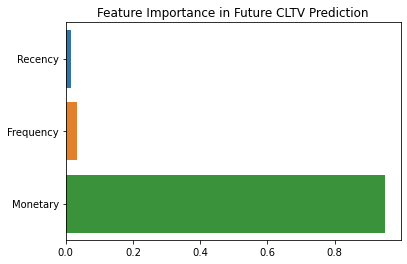

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = ['Recency', 'Frequency', 'Monetary']
importances = model.feature_importances_

sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance in Future CLTV Prediction")
plt.show()
